In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler


Dataset Preview:
   Gender   Age  Height  Weight family_history_with_overweight FAVC  FCVC  \
0  Female  21.0    1.62    64.0                            yes   no   2.0   
1  Female  21.0    1.52    56.0                            yes   no   3.0   
2    Male  23.0    1.80    77.0                            yes   no   2.0   
3    Male  27.0    1.80    87.0                             no   no   3.0   
4    Male  22.0    1.78    89.8                             no   no   2.0   

   NCP       CAEC SMOKE  CH2O  SCC  FAF  TUE        CALC  \
0  3.0  Sometimes    no   2.0   no  0.0  1.0          no   
1  3.0  Sometimes   yes   3.0  yes  3.0  0.0   Sometimes   
2  3.0  Sometimes    no   2.0   no  2.0  1.0  Frequently   
3  3.0  Sometimes    no   2.0   no  2.0  0.0  Frequently   
4  1.0  Sometimes    no   2.0   no  0.0  0.0   Sometimes   

                  MTRANS           NObeyesdad  
0  Public_Transportation        Normal_Weight  
1  Public_Transportation        Normal_Weight  
2  Public_Trans

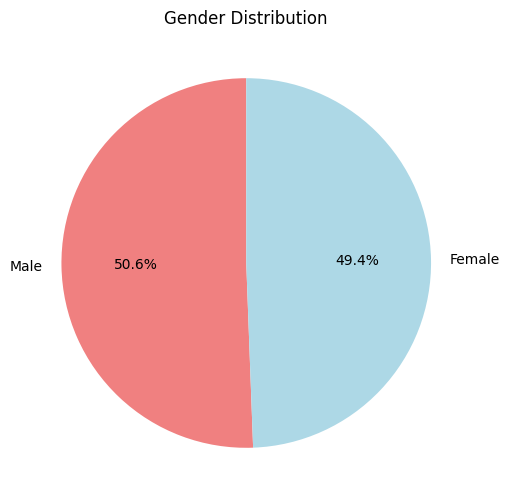

/var/folders/4s/s7qdjhcd0cz0cgj1ycyfntc40000gn/T/ipykernel_93017/2623307327.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='NObeyesdad', data=data, palette='pastel', order=data['NObeyesdad'].value_counts().index)


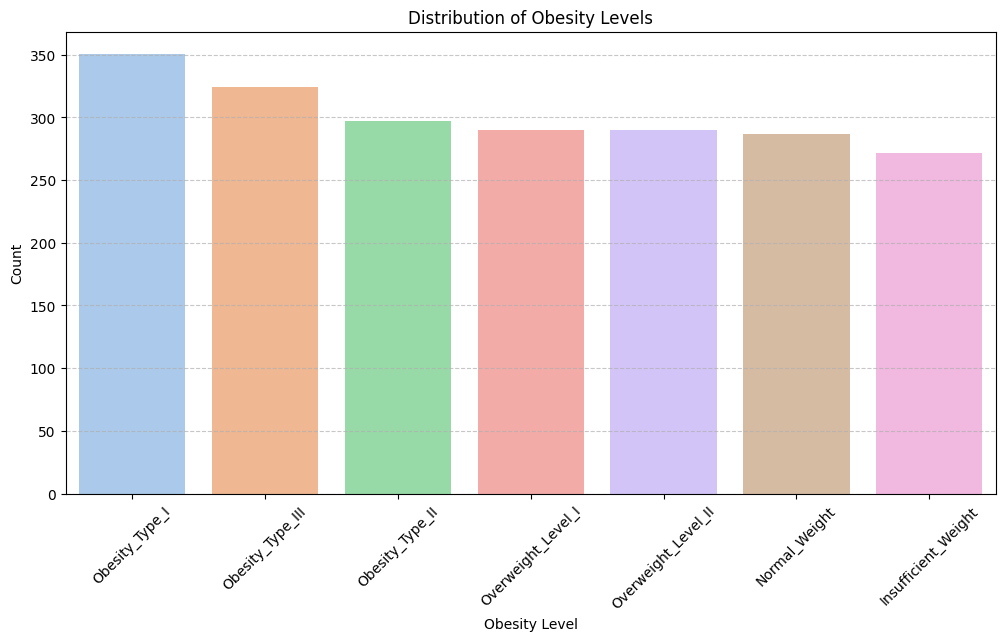

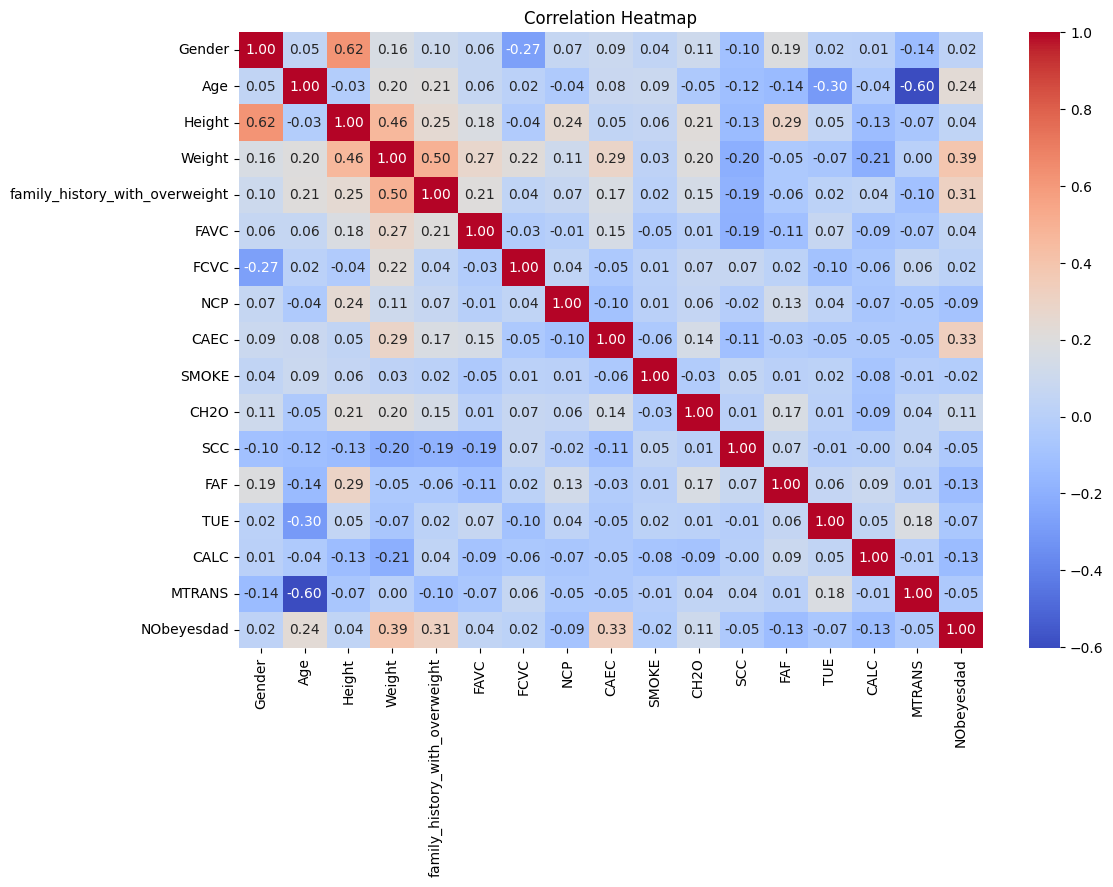

In [3]:
# Load the dataset
file_path = "ObesityDataSet_raw_and_data_sinthetic.csv"
data = pd.read_csv(file_path)

# Preview the dataset
print("Dataset Preview:")
print(data.head())

missing_values = data.isnull().sum()
print("\nMissing Values in Each Column:")
print(missing_values)

# Data Processing
# Convert categorical columns to category type
categorical_cols = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
for col in categorical_cols:
    data[col] = data[col].astype('category')

# Convert categories to numeric codes for analysis
data_encoded = data.copy()
for col in categorical_cols:
    data_encoded[col] = data[col].cat.codes

# Visualization 1: Gender Distribution
plt.figure(figsize=(8, 6))
data['Gender'].value_counts().plot(kind='pie', autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=90)
plt.title("Gender Distribution")
plt.ylabel('')
plt.show()

# Visualization 2: Distribution of Obesity Levels
plt.figure(figsize=(12, 6))
sns.countplot(x='NObeyesdad', data=data, palette='pastel', order=data['NObeyesdad'].value_counts().index)
plt.title("Distribution of Obesity Levels")
plt.xlabel("Obesity Level")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Visualization 3: Correlation Heatmap (Numeric Variables)
plt.figure(figsize=(12, 8))
sns.heatmap(data_encoded.corr(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()


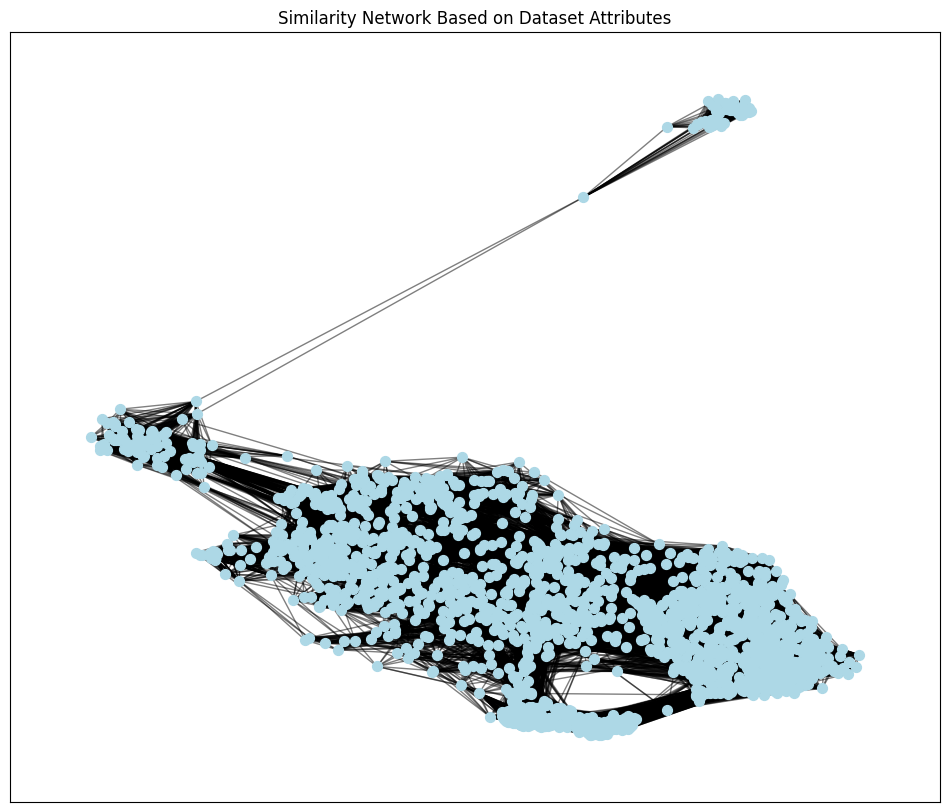

Number of Communities Detected: 4


/var/folders/z0/96ny8_cd205fzcytnj4zytw80000gn/T/ipykernel_52418/2655681117.py:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  community_obesity_counts = data.groupby(['Community', 'NObeyesdad']).size().unstack().fillna(0)


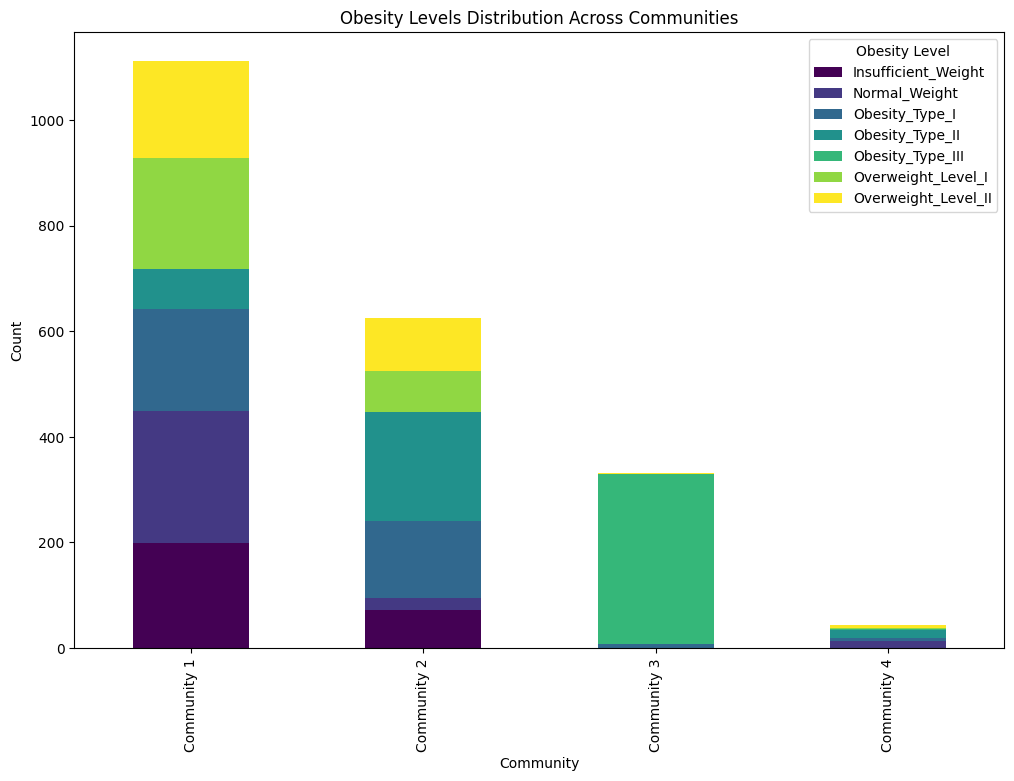

In [52]:
from networkx.algorithms.community import greedy_modularity_communities

scaler = StandardScaler()
# Drop target column from sim matrix
data_encoded = data_encoded.iloc[: , :-1]
data_normalized = scaler.fit_transform(data_encoded)
similarity_matrix = cosine_similarity(data_normalized)

G = nx.Graph()
for i in range(len(data)):
    G.add_node(i, label=data.iloc[i]['NObeyesdad'])

threshold = 0.6
for i in range(len(data)):
    for j in range(i + 1, len(data)):
        if similarity_matrix[i, j] > threshold:
            G.add_edge(i, j, weight=similarity_matrix[i, j])

plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=50, node_color='lightblue')
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.title("Similarity Network Based on Dataset Attributes")
plt.show()

communities = list(greedy_modularity_communities(G))
print(f"Number of Communities Detected: {len(communities)}")

community_labels = {node: f"Community {i+1}" for i, community in enumerate(communities) for node in community}
data['Community'] = [community_labels.get(i, "Unclassified") for i in range(len(data))]

community_obesity_counts = data.groupby(['Community', 'NObeyesdad']).size().unstack().fillna(0)
community_obesity_counts.plot(kind='bar', stacked=True, figsize=(12, 8), colormap="viridis")
plt.title("Obesity Levels Distribution Across Communities")
plt.xlabel("Community")
plt.ylabel("Count")
plt.legend(title="Obesity Level")
plt.show()

In [53]:
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['category']).columns

community_summary = {}

for community, group in data.groupby('Community'):
    numerical_summary = group[numerical_cols].mean()
    categorical_summary = group[categorical_cols].mode().iloc[0]
    community_summary[community] = pd.concat([numerical_summary, categorical_summary])

community_summary_df = pd.DataFrame(community_summary).T

# Select top 3 features for each community based on numerical means or categorical modes
top_features_per_community = {}
for community in community_summary_df.index:
    community_features = community_summary_df.loc[community]
    sorted_features = community_features[numerical_cols].sort_values(ascending=False).head(3)
    top_features_per_community[community] = sorted_features.index.tolist()

# Display the top features for each community
print("\nTop 3 Features for Each Community:")
for community, features in top_features_per_community.items():
    print(f"{community}: {', '.join(features)}")

print("\nCommunity Summary:")
print(community_summary_df)



Top 3 Features for Each Community:
Community 1: Weight, Age, NCP
Community 2: Weight, Age, NCP
Community 3: Weight, Age, NCP
Community 4: Weight, Age, NCP

Community Summary:
                   Age    Height      Weight      FCVC       NCP      CH2O  \
Community 1  24.341493  1.660693    71.11937  2.350985   2.43567  1.857659   
Community 2  24.470821  1.779621   96.086905  2.231732  2.963155  2.181811   
Community 3  23.385133  1.687349  119.946024    2.9942  2.995043  2.202363   
Community 4  28.312669  1.737161    91.20681  2.471433  2.727273  1.873628   

                  FAF       TUE  Gender family_history_with_overweight FAVC  \
Community 1  1.042236  0.638291  Female                            yes  yes   
Community 2  1.130196  0.712287    Male                            yes  yes   
Community 3  0.668012  0.611041  Female                            yes  yes   
Community 4  1.075671  0.731358    Male                            yes  yes   

                  CAEC SMOKE SCC     